In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL
import scipy
from IPython.display import clear_output as clr
%matplotlib inline

In [2]:
# Defining data directory
data_dir = os.getcwd() + '/../'
# Check in contents of current dir are same as expected
os.listdir(data_dir)

['.ipynb_checkpoints',
 '20news-18828.tar.gz',
 'corpuses',
 'LDA',
 'NMF',
 'stackoverflow-data-idf.json',
 'stackoverflow-test.json',
 'TF-IDF',
 'train_corpus',
 'Unigram']

In [3]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL

In [4]:
class preprocessor:
    
    def __init__(self):
        # word lemmatizer
        self.articles = 'a|an|and|the'
        self.lemmatizer = WNL()
        self.punctuations = string.punctuation
        self.translator = str.maketrans(string.punctuation, ' '*len(self.punctuations))
        
    def normalize_text(self, s):
        lower_s = self.lower(s)
        rem_p_s = self.remove_punc(lower_s)
        rem_a_s = self.remove_articles(rem_p_s)
        space_s = self.white_space_fix(rem_a_s)
        lemma_s = self.lemmatize(space_s)
        return lemma_s
        
    def lemmatize(self, txt):
        lemmatizer = self.lemmatizer
        return ' '.join(lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos = 'v'), pos = 'a') for word in txt.split())

    def remove_articles(self, text):
        return re.sub('\s+('+self.articles+')(\s+)', ' ',text)

    def white_space_fix(self, text):
        return ' '.join(text.split())

    def remove_punc(self, text):
        return text.translate(self.translator)

    def lower(self, text):
        return text.lower()

In [5]:
processor = preprocessor()

In [6]:
from nltk.corpus import brown
 
data = []
 
for fileid in brown.fileids():
    document = ' '.join(brown.words(fileid))
    data.append(processor.normalize_text(document))
#     if(len(data) >= 5):
#         break

In [7]:
class vocab:
    
    def __init__(self, corpus):
        """
        Corpus : list of docs
        """
        self.dictionary = {}
        self.vocab_size = 0
        self.make_vocab(corpus)
        self.inv_dictionary = {v: k for k, v in self.dictionary.items()}
    
    def make_vocab(self,corpus):
        
        count = 0
        for doc in corpus:
            for word in doc.strip().split():
                if(word in self.dictionary.keys()):
                    pass
                else:
                    self.dictionary[word] = count
                    count += 1
        
        self.vocab_size = count
        assert(len(self.dictionary.keys()) == count), "Wrong Number of words added"
        
    def get_index(self,word):
        if(word in self.dictionary.keys()):
            return self.dictionary[word]
        else:
            return -1
    
    def get_word(self,index):
        if(index in self.inv_dictionary.keys()):
            return self.inv_dictionary[index]
        else:
            return " "

In [8]:
myDict = vocab(data)

In [9]:
myDict.vocab_size

34110

In [10]:
def make_mat(corpus, vocab):
    
    D = len(corpus)
    V = vocab.vocab_size
    mat = np.zeros((V, D))
    for i in range(len(corpus)):
        doc = corpus[i]
        for word in doc.strip().split(" "):
            index = vocab.get_index(word)
            mat[index,i] += 1
    return mat

In [11]:
X = make_mat(data, myDict)

In [12]:
X.shape

(34110, 500)

In [38]:
def NMF(X, k, Winit = None, Hinit = None, convex = True, max_iter = None, pprint = False):    
    V, D = X.shape
    eps = 0.0001
    diff = 10
    c_iter = 0
    
    if(max_iter is None):
        max_iter  = 100
    
    if(Winit is None):
        W = np.random.rand(V, k)
        H = np.random.rand(k, D)
    else:
        W = Winit
        H = Hinit

        
    while(diff > eps and c_iter < max_iter):
        W_old = W.copy()
        H_old = H.copy()
        c_iter+=1
    
        if(convex):
            H = H/np.sum(H, axis =1).reshape(-1,1)
        W = W*(np.dot(X,H.T)/np.dot(W,np.dot(H, H.T)))
        H = H*(np.dot(W.T,X)/np.dot(W.T,np.dot(W,H)))
        
        diff = np.sum(np.square(W_old - W))
        if(c_iter%10 == 0 and pprint):
            print(diff)
    return W, H

In [ ]:
W, H = NMF(X, 20)

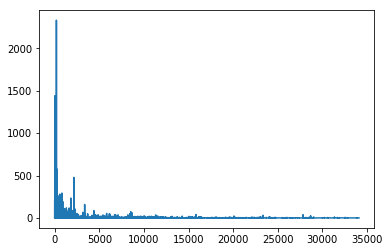

In [90]:
plt.plot(W[:,10])

In [91]:
indices = np.argsort(W[:,17])[0:10]

In [92]:
for i in indices:
    print(myDict.get_word(i))

biosynthesized
mungus
fungus
overweight
beriberi
neuralgia
neuritis
balmy
polyunsaturated
serafin


In [53]:
def PF(X, k, Winit = None, Hinit = None, convex = True, max_iter = None, pprint = False, lr = 0.0000001):    
    V, D = X.shape
    eps = 0.0001
    diff = 10
    c_iter = 0
    
    if(max_iter is None):
        max_iter  = 100
    
    if(Winit is None):
        W = np.random.rand(V, k)
        H = np.random.rand(k, D)
    else:
        W = Winit
        H = Hinit

        
    while(diff > eps and c_iter < max_iter):
        W_old = W.copy()
        H_old = H.copy()
        c_iter+=1
    
        if(convex):
            H = H/np.sum(H, axis =1).reshape(-1,1)
        
        var = ((X/(np.dot(W,H)))-1)
        
        for i in range(V):
            dLwi = np.sum(var[i,:]*H, axis = 1)
            W[i,:] -= lr*dLwi
            
        var = ((X/(np.dot(W,H)))-1)
            
        for j in range(D):
            dLhj = np.sum(W*var[:,j].reshape(-1,1), axis = 0)
            H[:,j] -= lr*dLhj
        
#         W -= lr*dLw
#         H -= lr*dLh
            
        diff = np.sum(np.square(W_old - W))
        if(c_iter%10 == 0 and pprint):
            print(diff)
    return W, H

In [ ]:
W, H = PF(X, 5, convex = False, max_iter = 100, pprint = True ,lr =0.00001)

395.7456107967818
74.47880105661426


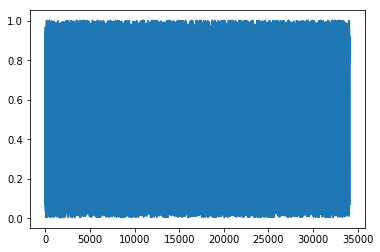

In [57]:
plt.plot(W[:,0])